In [1]:
import torchvision
import torch
import torch.nn as nn
import numpy as np
from torch import optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from skimage import io
import time
import ast 
from PIL import *
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random 

# import dicom 
import pydicom as dicom
import scipy.ndimage

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
df = pd.read_csv("large_nodules.csv")

# filter the size. 
df = df[df['areas'] >= 1000]  

# check cols are "path", "imageName", "SOPInstanceUID", "boxes", "areas"
df.head()

,path,imageName,SOPInstanceUID,boxes,areas
7,/scratch/ebc308/tcia/data/LIDC-IDRI/LIDC-IDRI-...,000075.dcm,1.3.6.1.4.1.14519.5.2.1.6279.6001.953341886624...,"[[161.0, 137.0, 201.0, 162.0]]",1000.0
78,/scratch/ebc308/tcia/data/LIDC-IDRI/LIDC-IDRI-...,000172.dcm,1.3.6.1.4.1.14519.5.2.1.6279.6001.358253510231...,"[[337.0, 189.0, 376.0, 224.0]]",1365.0
79,/scratch/ebc308/tcia/data/LIDC-IDRI/LIDC-IDRI-...,000174.dcm,1.3.6.1.4.1.14519.5.2.1.6279.6001.332771657417...,"[[335.0, 186.0, 375.0, 225.0]]",1560.0
80,/scratch/ebc308/tcia/data/LIDC-IDRI/LIDC-IDRI-...,000019.dcm,1.3.6.1.4.1.14519.5.2.1.6279.6001.133221309761...,"[[333.0, 189.0, 369.0, 219.0]]",1080.0
82,/scratch/ebc308/tcia/data/LIDC-IDRI/LIDC-IDRI-...,000175.dcm,1.3.6.1.4.1.14519.5.2.1.6279.6001.291261298826...,"[[334.0, 189.0, 374.0, 218.0]]",1160.0


In [4]:
# aspect ratio of anchors
aspectRatio = []
for index, row in df.iterrows():
    boxes = ast.literal_eval(row.boxes)
    width = float(boxes[0][2]) - float(boxes[0][0])
    height = float(boxes[0][3]) - float(boxes[0][1])
    aspectRatio.append(width / height)
print("dataset aspect ratio range:", min(aspectRatio), max(aspectRatio))

# max / min of area
print("dataset area range:", min(df['areas']), max(df['areas']))

# area > 1000
scales = [32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54]
aspect_ratios = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5]

# area > 100
# scales = list(range(10, 54))
# s = [10, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52]
# aspect_ratios = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.50]
calculate_scales = torch.as_tensor(scales)
calculate_aspect_ratios = torch.as_tensor(aspect_ratios)
h_ratios = torch.sqrt(calculate_aspect_ratios)
w_ratios = 1 / h_ratios

ws = (w_ratios[:, None] * calculate_scales[None, :]).view(-1)
hs = (h_ratios[:, None] * calculate_scales[None, :]).view(-1)

base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2
base_anchors = (base_anchors.round())
anchorArea = []
for each in base_anchors:
    each = each.numpy()
    width = each[2] * 2
    height = each[3] * 2
    area = width * height
    anchorArea.append(area)
#     print(each, " area: ", area)
    
print("anchor area range: ", min(anchorArea), max(anchorArea))

dataset aspect ratio range: 0.5471698113207547 2.4827586206896552
dataset area range: 1000.0 2880.0
anchor area range:  1000.0 2924.0


In [5]:
# split dataset into 60, 20, 20 
train_data, test_data = train_test_split(df, test_size=0.40, random_state=2020)
valid_data, test_data = train_test_split(test_data, test_size=0.50, random_state=2020)
train_data.index = np.arange(len(train_data))
valid_data.index = np.arange(len(valid_data))
test_data.index = np.arange(len(test_data))

In [6]:
# make into new csv files
train_data.to_csv("large_nodules_train.csv", index=False)
valid_data.to_csv("large_nodules_valid.csv", index=False)
test_data.to_csv("large_nodules_test.csv", index=False)

In [7]:
# for preprocessing dicom images - modified for 2d images.
# https://www.kaggle.com/akh64bit/full-preprocessing-tutorial
def load_scan(path):
    slices = [dicom.read_file(path)]
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
#     spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))
    # not 3d
    spacing = spacing[1:]

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    
#     background_label = labels[0,0,0]
    background_label = labels[0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
#     l_max = largest_label_volume(labels, bg=0)
#     if l_max is not None: # There are air pockets
#         binary_image[labels != l_max] = 0
 
    return binary_image

MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND) * 255.
    image[image>255] = 255.
    image[image<0] = 0.
    return image

# calculated previously.
PIXEL_MEAN = 0.32
# PIXEL_MEAN = 0.39

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [8]:
# custom transforms
class RandomHorizontalFlip(object):

    """Randomly horizontally flips the Image with the probability *p*
    Parameters
    ----------
    p: float
        The probability with which the image is flipped
    Returns
    -------
    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        img, bboxes = sample['image'], sample['boxes']
        img = np.array(img)
        if random.random() < self.p:
            img = img[::-1]
            ymax = (256-bboxes[0][1]) + 256 #ymin
            ymin = (256-bboxes[0][3]) + 256 #ymax
#             fig,ax = plt.subplots(1, figsize=(5,5))
#             ax.imshow(img, cmap="gray")
#             rect = patches.Rectangle((bboxes[0][0], bboxes[0][1]),(bboxes[0][2] - bboxes[0][0]),(bboxes[0][3] - bboxes[0][1]),linewidth=1,edgecolor='r',facecolor='none')
#             ax.add_patch(rect)
#             new = patches.Rectangle((bboxes[0][0], ymin),(bboxes[0][2] - bboxes[0][0]),(ymax - ymin),linewidth=1,edgecolor='b',facecolor='none')
#             ax.add_patch(new)
#             plt.show()
            bboxes[0][1] = ymin
            bboxes[0][3] = ymax

        return {'image': (img),
                'boxes': (bboxes)}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
#         image = image.transpose((2, 0, 1))
        toTen = transforms.ToTensor()
        image = toTen(image.copy())
        return {'image': (image),
                'boxes': (boxes)}

In [9]:
from torchvision import transforms
# torchvision models are trained on input images normalized to [0 1] range .ToPILImage() function achives this
# additional normalization is required see: http://pytorch.org/docs/master/torchvision/models.html

# no training data augmentation yet
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512,512),interpolation=Image.NEAREST)]) #scale image up to 512,512
#         transforms.ToTensor()])

composed = transforms.Compose([RandomHorizontalFlip(),
                               ToTensor()])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512,512),interpolation=Image.NEAREST),
        transforms.ToTensor()])

class Faster_RCNN_Dataloader(Dataset):
    """Chest X-ray dataset from https://nihcc.app.box.com/v/ChestXray-NIHCC."""

    def __init__(self, csv_file, transform=None, train=True):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.train = train
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        
        # get image path
        img_name = (self.data_frame.iloc[idx, 0])
        
        #dicom image preprocessing
        scan = load_scan(img_name)
        scan_pixels = get_pixels_hu(scan)
        pix_resampled, spacing = resample(scan_pixels[0], scan, [1,1])
        segmented_lungs = segment_lung_mask(pix_resampled, False)
        normal = normalize(segmented_lungs)
        avg = np.mean(normal, axis=(0, 1))
        image = zero_center(normal)
        d = {}
    
#         image = (image - image.min())/(image.max() - image.min()) * 255.0
#         print('normalized: Min: %.3f, Max: %.3f' % (image.min(), image.max()))
        
        if self.transform:
            image = self.transform(np.uint8(image))
            if (self.train):
                boxes = torch.FloatTensor(ast.literal_eval(self.data_frame.iloc[idx, 3]))
                sample = {'image': image, 'boxes': boxes}
                transformed = composed(sample)
                image = transformed['image']
                d['boxes'] = transformed['boxes']
                d['labels'] = torch.ones([1], dtype=torch.int64)
            else:
                d['boxes'] = torch.FloatTensor(ast.literal_eval(self.data_frame.iloc[idx, 3]))
                d['labels'] = torch.ones([1], dtype=torch.int64)

        # 1 channel to 3 channel
        image = image.numpy()
        image = np.stack((image,)*3, axis=-1)
        image = image[0]
#         print(len(image), len(image[0]), len(image[0][0]), len(image[0][0]))
        image = np.transpose(image,(2,0,1))
#         print(len(image), len(image[0]), len(image[0][0]))
        image = torch.FloatTensor(image)
#         image = torch.permute(2, 0, 1) 
        return image, d

# change dataloader output to lists.
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    return list(xx), list(yy)

In [10]:
train_df_path = 'large_nodules_train.csv'
validate_df_path = 'large_nodules_valid.csv'
test_df_path = 'large_nodules_test.csv'

transformed_dataset = {'train': Faster_RCNN_Dataloader(train_df_path, transform=train_transform, train=True),
                       'validate':Faster_RCNN_Dataloader(validate_df_path, transform=validation_transform, train=False),
                       'test':Faster_RCNN_Dataloader(test_df_path, transform=validation_transform, train=False)}

# transformed_dataset = {'train': Faster_RCNN_Dataloader(train_df_path, transform=validation_transform, train=False),
#                        'validate':Faster_RCNN_Dataloader(validate_df_path, transform=validation_transform, train=False),
#                        'test':Faster_RCNN_Dataloader(test_df_path, transform=validation_transform, train=False)}
bs = 4

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, collate_fn = pad_collate, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [11]:
# check if dataloader loaded correctly
images1, targets1 = next(iter(dataloader['train']))
images2, targets2 = next(iter(dataloader['validate']))
images3, targets3 = next(iter(dataloader['test']))

# to check dim of list dataloader
# len(images3) # = batch
# len(images3[0]) # = channel
# len(images3[0][0]) # = height
# len(images3[4][0][0]) # = width

# print only one image from one batch

# images4, targets4 = next(iter(dataloader['train']))
# # print(len(images4))
# for i in targets4[0]['boxes'].numpy():
#     ymin, ymax = i[1],i[3] #ymin ymax        
#     xmin, xmax = i[0], i[2] #xmin, xmax
# print(xmin,ymin,xmax,ymax)
# fig,ax = plt.subplots(1, figsize=(5,5))
# ax.imshow(images4[0].squeeze().numpy(), cmap='gray')
# rect = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
# ax.add_patch(rect)
# plt.show()


# print all images from dataloader

# for images, targets in (dataloader['test']):
#     for i, img in enumerate(images):
#         for i in targets[i]['boxes'].numpy():
#             ymin, ymax = i[1],i[3] #ymin ymax        
#             xmin, xmax = i[0], i[2] #xmin, xmax
#             fig,ax = plt.subplots(1, figsize=(5,5))
#             ax.imshow(img[0].squeeze().numpy(), cmap="gray")
#             rect = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
#             ax.add_patch(rect)
#             plt.show()

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (nodule) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [13]:
# from torchvision.models.detection import FasterRCNN
from source_code.faster_rcnn import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator
from source_code.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone = torchvision.models.mobilenet_v2().features

# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios

# anchor_generator = AnchorGenerator(sizes=((10, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52),),
#                                    aspect_ratios=((0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.50),))

# areas > 1000
# scales and aspect_ratios defined at the top chunk.
anchor_generator = AnchorGenerator(sizes=((scales),),
                                   aspect_ratios=((aspect_ratios),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler).to(device)  

# lt=3

count = 0
for child in model.children():
# #     print("child")
    if (count == 1):
#         print (child)
        p = 0
        for param in child.parameters():
            if (p < 154):
                # 54 backbone.6
                param.requires_grad = False
            p += 1
    count += 1

# count = 0
# for param in model.parameters():
#     param.requires_grad = False


# 0.01 / 0.1 wd 
# model.Sequential.weight.requires_grad = False
# model.InvertedResidual.bias.requires_grad = False

optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-100, weight_decay=1e-10)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-50)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9, weight_decay=0.0005)

lambda_func = lambda epoch: 0.5 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func) 

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 1)
# model.trainable

In [14]:
count = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print (count, name)
    count += 1

154 backbone.18.1.weight
155 backbone.18.1.bias
156 rpn.head.conv.weight
157 rpn.head.conv.bias
158 rpn.head.cls_logits.weight
159 rpn.head.cls_logits.bias
160 rpn.head.bbox_pred.weight
161 rpn.head.bbox_pred.bias
162 roi_heads.box_head.fc6.weight
163 roi_heads.box_head.fc6.bias
164 roi_heads.box_head.fc7.weight
165 roi_heads.box_head.fc7.bias
166 roi_heads.box_predictor.cls_score.weight
167 roi_heads.box_predictor.cls_score.bias
168 roi_heads.box_predictor.bbox_pred.weight
169 roi_heads.box_predictor.bbox_pred.bias


In [15]:
# move dict/lists to gpu 
def move_to(obj, device):
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        res = {}
        for k, v in obj.items():
            res[k] = move_to(v, device)
        return res
    elif isinstance(obj, list):
        res = []
        for v in obj:
            res.append(move_to(v, device))
        return res
    else:
        raise TypeError("Invalid type for move_to")

In [16]:
classes = ['__background__', 'nodule']

In [17]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(float(boxA[0]), float(boxB[0]))
    yA = max(float(boxA[1]), float(boxB[1]))
    xB = min(float(boxA[2]), float(boxB[2]))
    yB = min(float(boxA[3]), float(boxB[3]))
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [18]:
# have loss / accuracy in case training is interrupted
outsideLoss = []
outsideValidLoss = []
outsideAcc = []
outsideIOU = []

loss_classifier_list = []
loss_box_reg_list = []
loss_objectness_list = []
loss_rpn_box_reg_list = []
    
loss_objectness_valid = []
loss_rpn_box_reg_valid = []

def train_model(model, dataloader,optimizer, scheduler, iou_threshold = 0, num_epochs = 10, verbose = True):
    phases = ['train','validate']
    since = time.time()
    best_acc = 0
    epochLossTrain = list() # loss for train
    epochAccTrain = list()
    
    epochLossValidate = list()
    epochAccValidate = list() # how many images' highest confidence score has an iou > 0
    epochAccIOU = list()
    
    running_correct = 0
    running_loss = 0
    running_total = 0
    loss_classifier_r = 0
    loss_box_reg_r = 0
    loss_objectness_r = 0
    loss_rpn_box_reg_r = 0

    maybe_ap = []
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        losslist = []
        for p in phases:
            if p == 'train':
                model.train()
            else:
                model.eval()   
                validateAcc = 0
                totalImg = 0
                IOUAvg = []
                ap = []
            num = 0 # calculate which batch # --> enumerate not working
            for image, target in dataloader[p]:
                
#                 print("original target: ", target)
#                 optimizer.zero_grad()
#                 image = [img.to(device) for img in image]
#                 targetModel = [{k: v.to(device) for k, v in t.items()} for t in target]
                
                image = move_to(image,device)
                target = move_to(target,device)
#                 print("og target: ", target)
#                 print(target)
                if (num % int(len(dataloader[p])/4) == 0):
                    print('{} set | epoch: {:3d} | {:6d}/{:6d} batches'.format(p, i, num, len(dataloader[p])))
                num = num + 1
                if p == 'train':
                    # loss = sum of all 4 losses returned
                    lossDict, output = model((image), target)
#                     print (lossDict['loss_classifier'])
                    loss_classifier = lossDict['loss_classifier']
                    loss_box_reg = lossDict['loss_box_reg']
                    loss_objectness = lossDict['loss_objectness']
                    loss_rpn_box_reg = lossDict['loss_rpn_box_reg']
#                     print("POST MODEL", target)
                    loss = sum(loss for loss in lossDict.values())
#                     print(loss)
#                     print(output)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                if p == 'validate':
                    # helps with memory 
                    with torch.no_grad():
                        model.eval()  
                        lossDict, output = model((image), target)
                        loss = sum(loss for loss in lossDict.values())
                        
#                         print(lossDict)
                        loss_objectness = lossDict['loss_objectness']
                        loss_rpn_box_reg = lossDict['loss_rpn_box_reg']
        
                        pred_score = [] # confidence score
                        pred_boxes = [] # bounding box
                        pred_class = [] # predicted class
                        # loop through output (len(output) = batch size)
                        for j, out in enumerate(output):
                            totalImg += 1 
                            
                            # documentation: ['boxes'] = [x1, y1, x2, y2]
                            pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(out['boxes'].cpu().detach().numpy())]
                            pred_score = list(out['scores'].cpu().detach().numpy())
                            pred_class = [classes[i] for i in list(out['labels'].cpu().numpy())]
                            
                            # get labeled  bounding box
                            # documentation: # 0 xmin, 1 ymin, 2 xmax, 3 ymax
                            t = target[j]['boxes'].cpu().detach().numpy()[0]
                            target_box =  [t[0],t[1],t[2],t[3]]
                            
                            max_score_index = pred_score.index(max(pred_score))
                            max_score_IOU = bb_intersection_over_union(target_box, pred_boxes[max_score_index])
                            # calculate how many top confidence has iou > 0
                            if (max_score_IOU > iou_threshold):
                                validateAcc += 1
                                IOUAvg.append(max_score_IOU)
                            
                            
                # printing average loss / epoch
                num_imgs = len(image)
                running_loss += loss*num_imgs
                running_total += num_imgs  
                
                loss_classifier_r += loss_classifier*num_imgs
                loss_box_reg_r += loss_box_reg*num_imgs
                loss_objectness_r += loss_objectness*num_imgs
                loss_rpn_box_reg_r += loss_rpn_box_reg*num_imgs
                
                
            # keep epoch loss / accuracy (for validation)
            if p == 'train':
                epoch_loss = float(running_loss/running_total)
                epochLossTrain.append(epoch_loss)
                
                loss_classifier_list.append(float(loss_classifier_r/running_total))
                loss_box_reg_list.append(float(loss_box_reg_r/running_total))
                loss_objectness_list.append(float(loss_objectness_r/running_total))
                loss_rpn_box_reg_list.append(float(loss_rpn_box_reg_r/running_total))
                
                outsideLoss.append(epoch_loss) # in case model get cancelled 
            if p == 'validate':
                loss_objectness_valid.append(float(loss_objectness_r/running_total))
                loss_rpn_box_reg_valid.append(float(loss_rpn_box_reg_r/running_total))
                
                epoch_loss = float(running_loss/running_total)
                epochLossValidate.append(epoch_loss)
                outsideValidLoss.append(epoch_loss) 
                    
                epoch_acc = (validateAcc/totalImg) * 100.0
                if (len(IOUAvg) > 0):
                    print("average top iou: ", IOUAvg)
                    avgIOU = sum(IOUAvg)/len(IOUAvg)
                else: 
                    avgIOU = 0
                epochAccValidate.append(epoch_acc)
                epochAccIOU.append(avgIOU)
        
                outsideAcc.append(epoch_acc)
                outsideIOU.append(avgIOU)
            if verbose or (i%10 == 0):
                if p == 'train':
                    print('Phase:{}, epoch loss: {:.4f}'.format(p, epoch_loss))
                if p == 'validate':
                    print('Phase:{}, epoch loss: {:.4f} | average accuracy: {:.4f} | average of (correctly predicted) iou {:.4f} | incorrect map: {:.4f}'.format(p, epoch_loss, epoch_acc, avgIOU, temp_ap))   
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
            
            # LambdaLR scheduler
                if scheduler:
                    scheduler.step()
                    # ReduceLROnPlateau
#                     scheduler.step(epoch_acc)
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, epochLossTrain, epochLossValidate  ,epochAccValidate, epochAccIOU


In [19]:
model, epochLossTrain, epochLossValidate, epochAccValidate, epochAccIOU = train_model(model, 
                                                                        dataloader, optimizer, 
                                                                        scheduler,
                                                                        iou_threshold = 0,
                                                                        num_epochs=10)


Epoch: 0/9
----------
train set | epoch:   0 |      0/    72 batches


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


train set | epoch:   0 |     18/    72 batches
train set | epoch:   0 |     36/    72 batches
train set | epoch:   0 |     54/    72 batches
Phase:train, epoch loss: 1.3567
validate set | epoch:   0 |      0/    24 batches
validate set | epoch:   0 |      6/    24 batches
validate set | epoch:   0 |     12/    24 batches
validate set | epoch:   0 |     18/    24 batches
average top iou:  [0.08900573957060463, 0.033753012877790374]
Phase:validate, epoch loss: 1.1901 | average accuracy: 2.0833 | average of (correctly predicted) iou 0.0614 | incorrect map: 0.0166
Epoch: 1/9
----------
train set | epoch:   1 |      0/    72 batches
train set | epoch:   1 |     18/    72 batches
train set | epoch:   1 |     36/    72 batches
train set | epoch:   1 |     54/    72 batches
Phase:train, epoch loss: 1.2620
validate set | epoch:   1 |      0/    24 batches
validate set | epoch:   1 |      6/    24 batches
validate set | epoch:   1 |     12/    24 batches
validate set | epoch:   1 |     18/    24

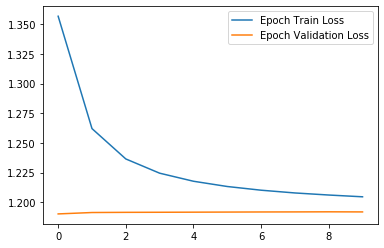

In [20]:
plt.plot(epochLossTrain, label = "Epoch Train Loss")
plt.plot(epochLossValidate, label = "Epoch Validation Loss")
plt.legend(loc = "upper right")

# if model gets cancelled, plot:
# plt.plot(outsideLoss, label = "Epoch Train Loss")
# plt.legend(loc = "upper right")

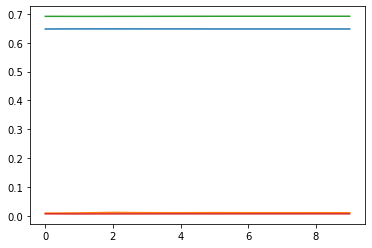

In [21]:
plt.plot(loss_classifier_list, label = "loss_classifier")
plt.plot(loss_box_reg_list, label = "loss_box_reg")
plt.plot(loss_objectness_list, label = "loss_objectness")
plt.plot(loss_rpn_box_reg_list, label = "loss_rpn_box_reg")

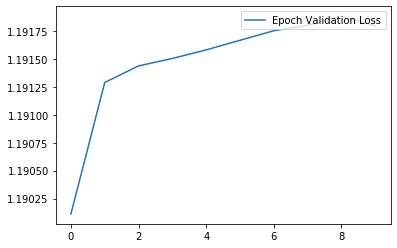

In [22]:
plt.plot(epochLossValidate, label = "Epoch Validation Loss")
plt.legend(loc = "upper right")

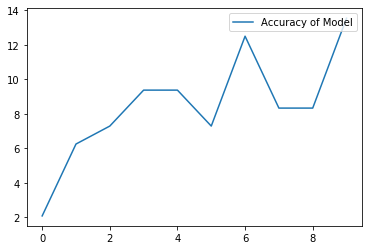

In [23]:
plt.plot(epochAccValidate, label = "Accuracy of Model")
plt.legend(loc = "upper right")

# if model gets cancelled, plot:
# plt.plot(outsideAcc, label = "Accuracy of Model")
# plt.legend(loc = "upper right")

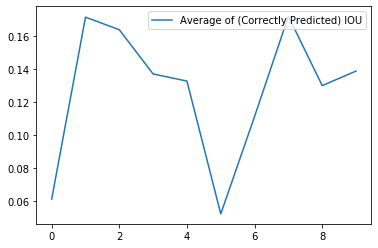

In [24]:
plt.plot(epochAccIOU, label = "Average of (Correctly Predicted) IOU")
plt.legend(loc = "upper right")
         
# plt.plot(outsideIOU, label = "Average of (Correctly Predicted) IOU")
# plt.legend(loc = "upper right")

iou:  0.07970451478021126
prediction box area:  3667.894 box area:  1122.0


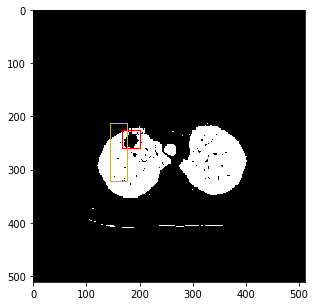

iou:  0.07079932110929975
prediction box area:  1171.1006 box area:  1485.0


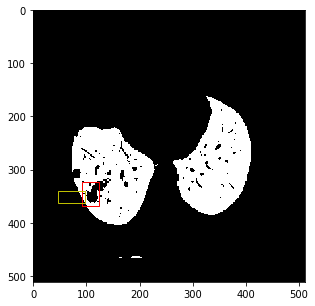

iou:  0.3257218860111919
prediction box area:  2798.5845 box area:  1044.0


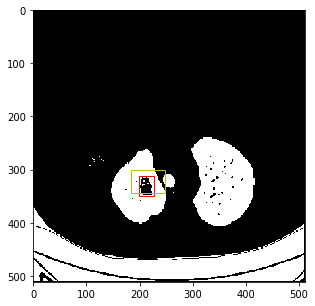

0.03125 0.40625


In [25]:
count = 0
total = 0
somePrediction = 0 
for images, targets in (dataloader['test']):
#     print(targets)
    with torch.no_grad():
        model.eval()
        images = move_to(images,device)
        targets = move_to(targets,device)
#         print(modelTargets)
        loss, pred = model(images, targets) # Pass the image to the model

    for i, img in enumerate(images):
        total += 1
        list_box = []
        for lab in targets[i]['boxes'].cpu().detach().numpy():
            ymin, ymax = lab[1], lab[3] #ymin ymax        
            xmin, xmax = lab[0], lab[2] #xmin, xmax
#             print(xmin, ymin, xmax, ymax)
            list_box.append(lab[0]) #xmin
            list_box.append(lab[1]) #ymin
            list_box.append(lab[2]) #xmax
            list_box.append(lab[3]) #ymax
            
        out = pred[i]
        pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(out['boxes'].cpu().detach().numpy())]
        pred_score = list(out['scores'].cpu().detach().numpy())
        pred_class = [classes[i] for i in list(out['labels'].cpu().numpy())]

        max_score_index = pred_score.index(max(pred_score))
        max_score = pred_boxes[max_score_index]
        
        if (bb_intersection_over_union((list_box),max_score) > 0):
            count += 1
            print("iou: ", bb_intersection_over_union((list_box),max_score))
            print("prediction box area: ", (max_score[2] - max_score[0]) * (max_score[3] - max_score[1]), "box area: ", (list_box[2] - list_box[0]) * (list_box[3] - list_box[1]))
            fig,ax = plt.subplots(1, figsize=(5,5))
            ax.imshow(img[0].cpu().squeeze().numpy(), cmap="gray")
#             label = patches.Rectangle((, list_box[1] ),(list_box[2] - list_box[0]),(list_box[3] - list_box[1]),linewidth=1,edgecolor='r',facecolor='none')
            label = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
            maxScore = patches.Rectangle((max_score[0], max_score[1] ),(max_score[2] - max_score[0]),(max_score[3] - max_score[1]),linewidth=1,edgecolor='y',facecolor='none')
            ax.add_patch(label)
            ax.add_patch(maxScore)
            plt.show()
        if_once = False
        for i, ind in enumerate(pred_boxes):
            if (bb_intersection_over_union((list_box),(ind)) > .2):
                if_once = True
#                 fig,ax = plt.subplots(1, figsize=(5,5))
#                 ax.imshow(img[0].cpu().squeeze().numpy(), cmap="gray")
#                 label = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
#                 label = patches.Rectangle((list_box[0], list_box[1] ),(list_box[2] - list_box[0]),(list_box[3] - list_box[1]),linewidth=1,edgecolor='r',facecolor='none')
#                 maxScore = patches.Rectangle((max_score[0], max_score[1] ),(max_score[2] - max_score[0]),(max_score[3] - max_score[1]),linewidth=1,edgecolor='y',facecolor='none')
#                 prediction = patches.Rectangle((ind[0], ind[1] ),(ind[2] - ind[0]),(ind[3] - ind[1]),linewidth=1,edgecolor='b',facecolor='none')
#                 ax.add_patch(label)
#                 ax.add_patch(maxScore)
#                 ax.add_patch(prediction)
#                 plt.show()   
#                 print("prediction box area: ", (ind[2] - ind[0]) * (ind[3] - ind[1]), "box area: ", ((list_box[2] - list_box[0]) * (list_box[3] - list_box[1])))
#                 print("highest score:" ,max(pred_score), " min: ", min(pred_score))
#                 print("predicted score:" , pred_score[i], "iou:", bb_intersection_over_union((list_box),(ind)))
#                 print("all scores" , i)
        
        if if_once:
            somePrediction += 1
print(count/total, somePrediction/total)
